<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/jax_phi4_HMCsimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phi-4 Theory with Hamiltonian Monte Carlo Sampler

In case of Gibbs-like field theory for $\varphi^4$ potential, the lattice "energy" is
$$
U(\phi) = \sum_x \left[ -2\beta \sum_{(y,x)}\phi(x)\phi(y) + (1-2\lambda)\phi(x)^2 + \lambda \phi(y)^4\right]
$$
where $x$ runs over all lattice node of a $N^d$ grid (d=2 in the use-case), $(y,x)$ means node $y$ closest to node $x$ considering on the edges a circular padding. (Nb. sometimes $2\beta \rightarrow \beta$ in some article, and vice-versa).

Notice that the $\beta$-term is the Laplacien and can be written as
$$
\sum_{(y,x)}\phi(x)\phi(y)   = \sum_{\mu=1}^d \phi(x) \phi(x+\hat{\mu})
$$
with $\hat{\mu}$ a unit-vector in the $\mu$-direction.


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
from functools import partial

In [ ]:
# this is a crude test pay attention if you run on a GPU that it pass the test
gpu = "cuda" in str(jax.devices()[0])
gpu

True

In [ ]:
def plot_3img(image1,image2, image3, title_1='',title_2='', title_3='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    if vminmax is None:
        vmin = image1.mean() - 3*image1.std()
        vmax = image1.mean() + 3*image1.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image1, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title(title_1);
    img = axs[1].imshow(image2, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_2);
    img = axs[2].imshow(image3, vmin=vmin, vmax=vmax, cmap=cmap); axs[2].set_title(title_3);
    axs[0].set_xticks([]); axs[1].set_xticks([]); axs[2].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([]); axs[2].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());

In [ ]:
def lattice_init(key,batch_size,N,d):
    shape = [batch_size]+[N for _ in range(d)]
    phi = 0.1*jax.random.normal(key,shape) # jnp.zeros(shape=shape)  #   #     # init with uniform field value =0
    return phi

In [ ]:
@jax.jit
def get_Batch_S(phi,params):  # Ok wrt torch
    """ get dimless action
    phi : tensor Batch x L^d
    params : lambda, kapa, h
    """
    l,k,h = params
    dtot = jnp.ndim(phi)  # d: total number of dimensions 1+d
    d = range(1,dtot)
    action = (1 - 2 * l) * phi**2 + l * phi**4 + h*phi
    for mu in d:
        action += -2.* k * phi * jnp.roll(phi, 1, mu)
    return action.sum(axis=d) # here the sum over dims except Batch

In [ ]:
@jax.jit
def get_Batch_force(phi,params): # Ok wrt torch
    """ get dimless force = - gradient of action
    phi : tensor Batch x L^d
    params : lambda, kapa, h
    """
    l,k,h = params
    dtot = jnp.ndim(phi)  # d: total number of dimensions 1+d
    d = range(1,dtot)

    force = 2 * phi * (2 * l * (1 - phi**2) - 1) - h
    for mu in d:
        force += 2. * k * (jnp.roll(phi, 1, mu) + jnp.roll(phi, -1, mu))

    return force

def get_Batch_gradS(phi,params):
    return -get_Batch_force(phi,params)

In [ ]:
# Not used
@jax.jit
def get_action(phi,params):
    """ get dimless action
    phi : dim L^d
    params : lambda, kapa, h
    """
    l,k,h = params
    d= jnp.ndim(phi)
    action = (1 - 2 * l) * phi**2 + l * phi**4 + h*phi
    for mu in range(d):
        action += -2.* k * phi * jnp.roll(phi, 1, mu)
    return action.sum()

# vectorized action to be called with a collection of phi : tensor Batch x L^2
v_action = jax.jit(jax.vmap(get_action,in_axes=(0,None)))

# vectorized action jacobian (minus the force) to be called with a collection of phi : tensor Batch x L^2
vjac_action = jax.jit(jax.vmap(jax.jacrev(get_action),in_axes=(0,None)))


In [ ]:
@jax.jit
def hmc_one_step(key,phi,params,n_steps=10,dt=0.1):
    """Return batch of updated phi, acceptance rate.
       warning: force is -grad(action)
    """

    dims = [i+1 for i in range(len(phi.shape)-1)]

    key, subkey0, subkey1 = jax.random.split(key,num=3)

    S = get_Batch_S(phi,params)

    new_phi = jnp.copy(phi)
    momentum = jax.random.normal(subkey0, shape=phi.shape)
    hamiltonian = 0.5 * jnp.sum(momentum**2, axis=dims) + S

    def update(i,carry):
        new_phi, momentum = carry
        new_phi += dt * momentum
        momentum += dt * get_Batch_force(new_phi,params)
        return new_phi, momentum

    momentum += 0.5 * dt *  get_Batch_force(new_phi,params)
    new_phi, momentum = jax.lax.fori_loop(0,n_steps-1,update,(new_phi, momentum))
    new_phi += dt * momentum
    momentum += 0.5 * dt *  get_Batch_force(new_phi,params)


    new_S = get_Batch_S(new_phi,params)
    d_hamiltonian = 0.5 * jnp.sum(momentum**2, axis=dims) + new_S - hamiltonian

    #metroplolis
    prob = jnp.exp(-d_hamiltonian)
    #jax.debug.print("prob: {}", prob)

    r = jax.random.uniform(subkey1, shape=prob.shape)
    #jax.debug.print("r: {}", r)
    accept = r < prob
    #jax.debug.print("accept1: {}", accept)

    shape = tuple([phi.shape[0]]+[1 for i in range(len(phi.shape)-1)])  # B,1...,1
    accept = accept.reshape(shape)
    res = jnp.where(accept, new_phi, phi)

    return res, accept

In [ ]:
import datetime
datetime.datetime.now().strftime("%H:%M:%S")
import tqdm.notebook as tqdm

In [ ]:
def run_hmc(
        key,
        n_iter,
        phi,
        verbose=True):
    if verbose:
        accept_rate = 0
        trange = tqdm.trange(n_iter)
        print(f"params={params},n_steps={n_steps},dt={dt}")
        for i in trange:
            key,subkey = jax.random.split(key)
            phi, accept = hmc_one_step(subkey,phi=phi,params=params,
                                   n_steps=n_steps,dt=dt)
            accept_rate += np.mean(accept)
            trange.set_postfix(acc=str(np.round(accept_rate / (i+1), 2)))
        print(f"\nacceptance rate: {accept_rate / n_iter}")
    else:
        for i in range(n_iter):
            if i<100 and i%10==0: print("itr:",i,datetime.datetime.now().strftime("%H:%M:%S"))
            if i%100 == 0: print("itr:",i,datetime.datetime.now().strftime("%H:%M:%S"))
            phi, _ = hmc_fn(phi)

    return phi

In [ ]:
batch_size = 10
L = 128
beta = 0.3#[0.2,0.255,0.3]
lam = 0.02
h = 0.0
key= jax.random.PRNGKey(40)
key,subkey = jax.random.split(key)
phi_init = jnp.zeros((batch_size,L,L)) # 0.5*jax.random.normal(subkey,(batch_size,L,L))
params=lam,beta,h
dt = 0.01

n_steps = 100
n_iter=1000


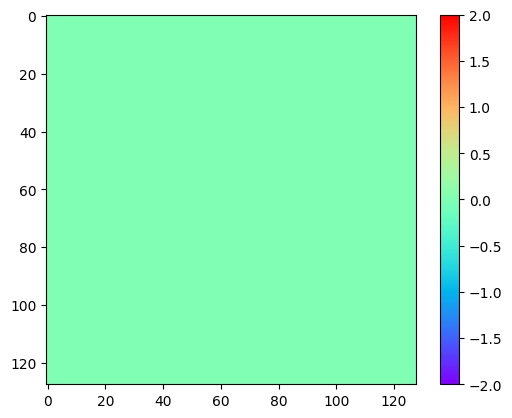

In [ ]:
imshow(phi_init[0],vmin=-2,vmax=2,cmap="rainbow")
colorbar()

In [ ]:
phi_state = run_hmc(
    subkey,
    n_iter=n_iter,
    phi=phi_init)

  0%|          | 0/1000 [00:00<?, ?it/s]

params=(0.02, 0.3, 0.0),n_steps=100,dt=0.01

acceptance rate: 0.9955005645751953


In [ ]:
phi_state.shape

(10, 128, 128)

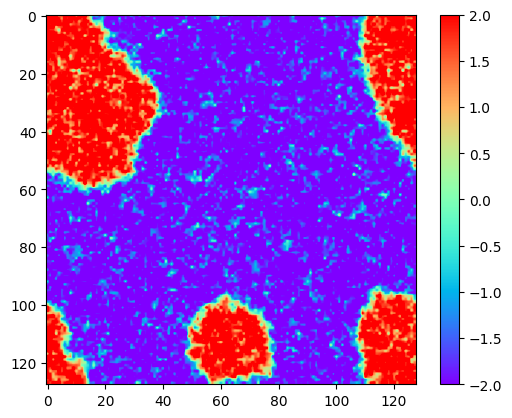

In [ ]:
imshow(phi_state[2],vmin=-2,vmax=2,cmap="rainbow")
colorbar()

In [ ]:
def simul_scan(kap, N=32, d=2, lam=0.02, h=0, seed=4, batch_size=1,n_burn=1000,n_spls=1000,
               n_thinning=1,dt=0.01, n_steps=100):
    """
    used by vmap other an array of kapa values
    return last phi fields and summary stat (see body_out)

    n_burn: # of iterations before sampling
    n_spls: # of summary stat values per kapa
    n_thinning:  # of iterations between 2 samples
    """

    params = (lam,kap,h)

    n_spls_eff =  n_spls // n_thinning

    def body_in(i,carry):
        subkeys,phi=carry
        phi, _ = hmc_one_step(subkeys[i],phi=phi,params=params,
                              n_steps=n_steps,dt=dt)
        return subkeys,phi

    def body_out(phi,keys): # carry, x
        _,phi = jax.lax.fori_loop(0,n_thinning,body_in,(keys,phi))
        mag = jnp.mean(phi)
        absmag = jnp.mean(jnp.abs(phi))
        mag2 =  mag*mag # jnp.mean(phi**2)
        mag4 = mag2 * mag2 # jnp.mean(phi**4)
        return  phi,(mag,absmag,mag2,mag4)  # carry, y

    #init
    key=jax.random.PRNGKey(seed)
    key,subkey = jax.random.split(key)
    phi = lattice_init(subkey,batch_size,N,d)

    #burn
    keys= jax.random.split(key,num=n_burn+1)
    key = keys[0]
    subkeys=keys[1:]
    _,phi = jax.lax.fori_loop(0,n_burn,body_in,(subkeys,phi))

    #sampling
    keys = jax.random.split(key,num=n_spls+1)
    key = keys[0]
    subkeys=keys[1:]

    subkeys=subkeys.reshape(n_spls_eff,subkeys.shape[0]//n_spls_eff,2)
    #print("sampling, subkeys shape=",subkeys.shape)

    phi_last, mags = jax.lax.scan(body_out, phi, subkeys)

    return phi_last, mags

In [ ]:
lam=0.02  # lambda
N=128    # size of the latice is N^2 (keep it <= 128)
key = jax.random.PRNGKey(4) # init random

In [ ]:
f = partial(simul_scan, N=N, d=2, lam=lam, h=0, seed=40, batch_size=1, n_burn=1000,n_spls=2,\
               n_thinning=1,dt=0.01, n_steps=100)

In [ ]:
betas = [0.2,0.255,0.3] # adapted for lambda = 0.02

In [ ]:
phi_last, _ = jax.jit(jax.vmap(f))(jnp.array(betas))

In [ ]:
phi_last.shape

(3, 1, 128, 128)

In [ ]:
phi_last= phi_last.squeeze()

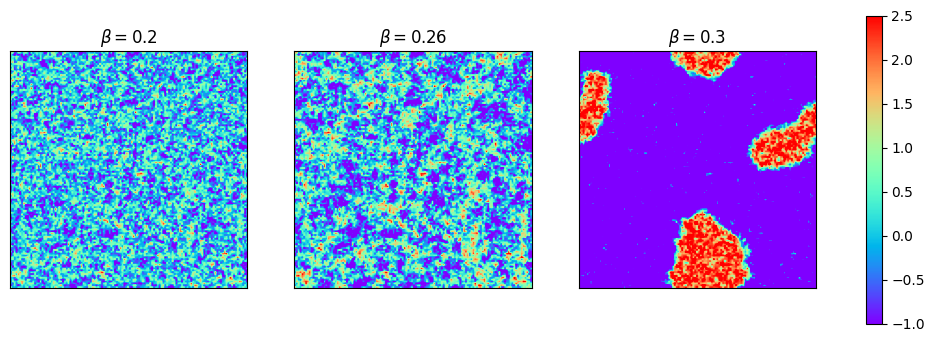

In [ ]:
plot_3img(phi_last[0],phi_last[1],phi_last[2], colorbar=True, figsize=(13, 4),
         title_1=rf"$\beta={betas[0]:.2}$",title_2=rf"$\beta={betas[1]:.2}$",title_3=rf"$\beta={betas[2]:.2}$",
          vminmax=(-1,2.5))


In [ ]:
# 70sec on V100, 2min T4
lam=0.02  # lambda
N=128    # size of the latice is N^2 (keep it <= 128)
betas = jnp.linspace(0.25,0.30,60)
f = partial(simul_scan, N=N, d=2, lam=lam, h=0, seed=40, batch_size=1, n_burn=5_000,n_spls=10_000,\
               n_thinning=1,dt=0.01, n_steps=100)

In [ ]:
_, mags_info= jax.jit(jax.vmap(f))(jnp.array(betas))

In [ ]:
mags = mags_info[0]
absmags = mags_info[1]
mags2 = mags_info[2]
mags4 = mags_info[3]

In [ ]:
mags2.shape

(60, 10000)

In [ ]:
V = N*N # total number of nodes
n_spls_eff = mags.shape[1]  #n_spls/n_thinning

In [ ]:
mean_mags = jnp.mean(jnp.abs(mags),axis=1)
err_mags  = jnp.std(jnp.abs(mags),axis=1)

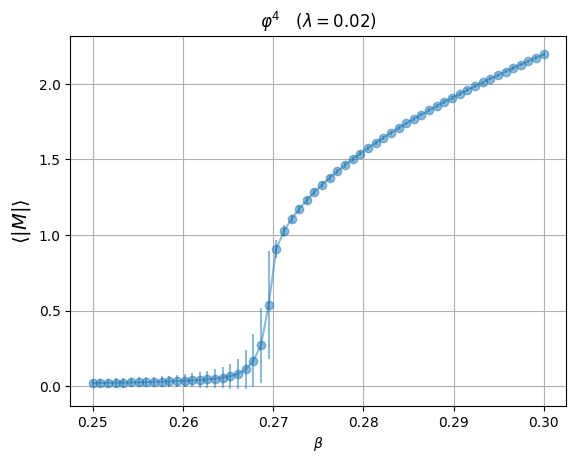

In [ ]:
errorbar(betas,mean_mags,yerr=err_mags,fmt='-o',alpha=0.5,label="simu")
grid()
xlabel(r"$\beta$")
ylabel(r"$\langle |M| \rangle$",fontsize=14)
title(rf"$\varphi^4 \quad(\lambda={lam})$");

In [ ]:
mean_mags2 = jnp.mean(mags2,axis=1)
chi2 = V*(mean_mags2-(mean_mags)**2)

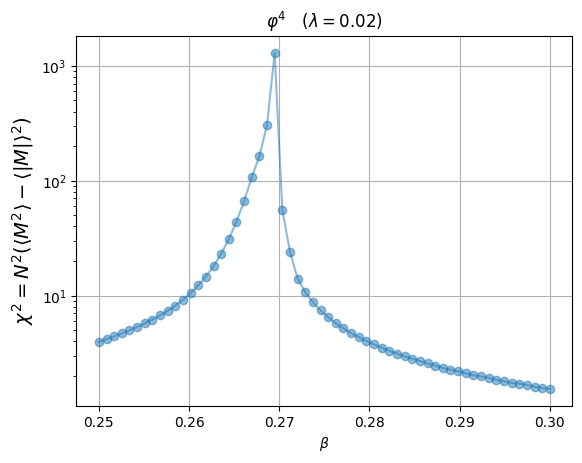

In [ ]:
errorbar(betas,chi2,yerr=0,fmt='-o',alpha=0.5,label="simu")
grid()
xlabel(r"$\beta$")
ylabel(r"$\chi^2=N^2 (\langle M^2 \rangle - \langle | M | \rangle^2)$",fontsize=14)
title(rf"$\varphi^4 \quad(\lambda={lam})$");
yscale("log");

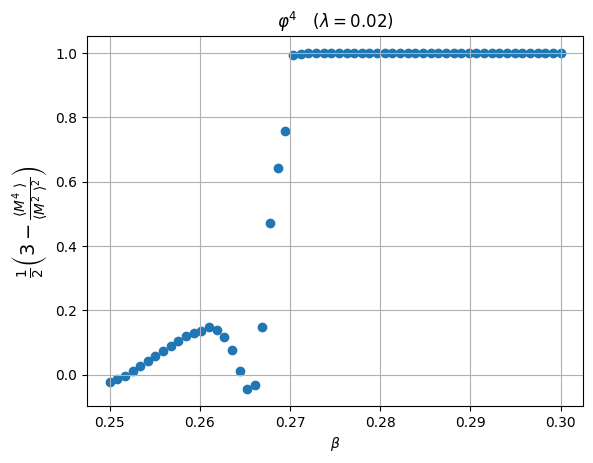

In [ ]:
if gpu:
    #errorbar(betas,UL,yerr=err_UL,fmt='-o',alpha=0.5,label="simu")
    a = np.mean(mags4,axis=1)
    b = np.mean(mags2,axis=1)
    UL = 0.5*(3-a/b**2)
    scatter(betas,0.5*(3-a/b**2))
    grid()
    xlabel(r"$\beta$")
    ylabel(r"$\frac{1}{2}\left(3-\frac{\langle M^4 \rangle}{\langle M^2 \rangle^2}\right)$",fontsize=14)
    title(rf"$\varphi^4 \quad(\lambda={lam})$");